In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

/home/ohya-lab/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ohya-lab/anaconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


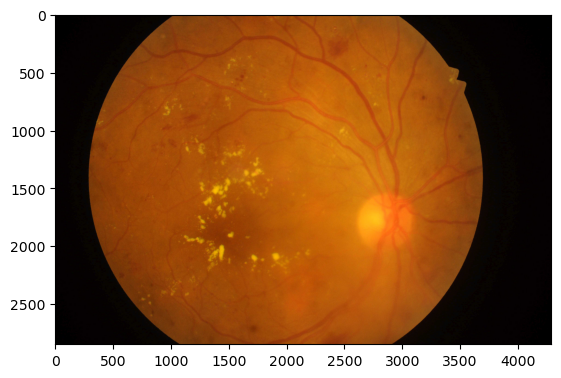

In [3]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('archive/Imagenes/Imagenes/IDRiD_001.jpg')
plt.imshow(img)

In [4]:
def get_input_transform():  
    transf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [5]:
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=3, bias=True),
    nn.Softmax(dim=1)
)

model.load_state_dict(torch.load('model.pt', map_location="cpu"))

/home/ohya-lab/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ohya-lab/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [6]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [7]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((224, 224)),
    ])    

    return transf

def get_preprocess_transform():  
    transf = transforms.Compose([
        transforms.ToTensor(),
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [8]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [9]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

2

In [10]:
from lime import lime_image

In [11]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
from skimage.segmentation import mark_boundaries

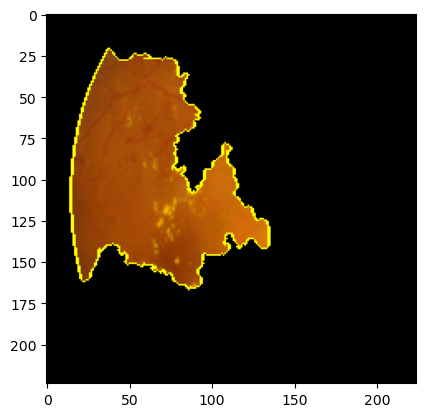

In [13]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

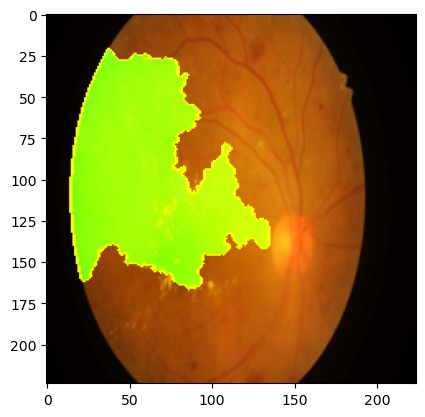

In [14]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=4, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)